In [280]:
from pymoo.problems.many.dtlz import DTLZ2
from pymoo.util.ref_dirs import get_reference_directions
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import matplotlib.pyplot as plt
import numpy as np

In [281]:
problem = DTLZ2(n_obj=2)
ref_dirs = get_reference_directions("das-dennis", 2, n_partitions=50)

In [282]:
output = {}
problem._evaluate(ref_dirs,output)

In [283]:
objective_value_1 = [i[0] for i in output['F']]
objective_value_2 = [i[1] for i in output['F']]
x1 = [i[0] for i in ref_dirs]
x2 = [i[1] for i in ref_dirs]
dict_data = {}

dict_data['x1'] = x1
dict_data['x2'] = x2
dict_data['Objective 1']  = objective_value_1
dict_data['Objective 2'] = objective_value_2
dataset = pd.DataFrame(data=dict_data)

In [284]:
dataset.head()

,x1,x2,Objective 1,Objective 2
0,0.00,1.00,1.250000,0.000000
1,0.02,0.98,1.229793,0.038648
2,0.04,0.96,1.209209,0.076077
3,0.06,0.94,1.188303,0.112328
4,0.08,0.92,1.167124,0.147442


##### MOdelling on Objective 1

In [285]:
X = dataset[['x1','x2']].to_numpy()
Y = dataset['Objective 1'].to_numpy().reshape(-1,1)

In [286]:
#kernel = C(1.0, (1e-3, 1e3)) * RBF([5,5], (1e-2, 1e2)) 
kernel =  RBF(length_scale=3) 
model = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=25,normalize_y=True).fit(X,Y)

c:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


In [287]:
x1 = dataset['x1'].to_numpy()
x2= dataset['x2'].to_numpy()
x1 = np.linspace(x1.min(), x2.max())
x2 = np.linspace(x2.min(), x1.max())

In [288]:
output = {}
problem._evaluate(x,output)
data = [i[0] for i in output['F']]

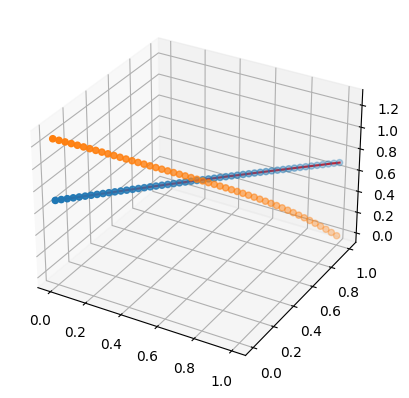

In [289]:
ax = plt.figure().add_subplot(projection='3d')
x= (np.array([x1,x2])).T
mean,std = model.predict(x,return_std=True)
ax.scatter(x1,x2,mean)
ax.scatter(x1,x2,data)
ax.plot(x1,x2,mean,color = 'red')


In [290]:
kernel_2 = C(1.0, (1e-3, 1e3)) * RBF([5,5], (1e-2, 1e2)) 
#kernel =  RBF(length_scale=3) 
model_2 = GaussianProcessRegressor(kernel=kernel_2,n_restarts_optimizer=30,normalize_y=True,random_state=11).fit(X,Y)
output = {}
x= (np.array([x1,x2])).T
problem._evaluate(x,output)
data = [i[0] for i in output['F']]

c:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


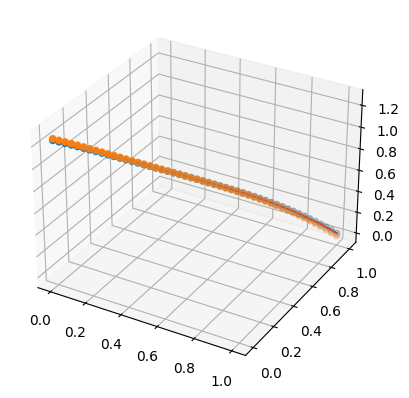

In [291]:
x1 = dataset['x1'].to_numpy()
x2= dataset['x2'].to_numpy()
x1 = np.linspace(x1.min(), x2.max())
x2 = np.linspace(x2.min(), x1.max())
ax = plt.figure().add_subplot(projection='3d')
x= (np.array([x1,x2])).T
mean_2,std_2 = model_2.predict(x,return_std=True)
ax.scatter(x1,x2,mean_2)
ax.scatter(x1,x2,data)
ax.plot(x1,x2,mean_2,color = 'red')


#### Model on Objective 2

In [294]:
X = dataset[['x1','x2']].to_numpy()
Y = dataset['Objective 2'].to_numpy().reshape(-1,1)
kernel_2 = C(1.0, (1e-3, 1e3)) * RBF([5,5], (1e-2, 1e2)) 
#kernel =  RBF(length_scale=3) 
model_2 = GaussianProcessRegressor(kernel=kernel_2,n_restarts_optimizer=30,normalize_y=True,random_state=12).fit(X,Y)

c:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


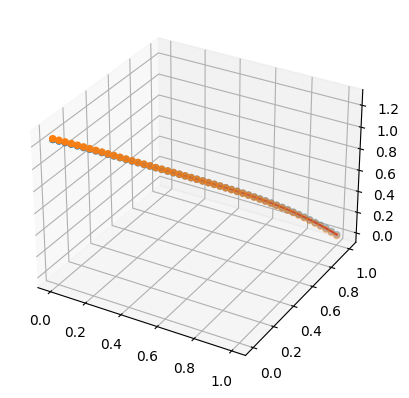

In [298]:
x1 = dataset['x1'].to_numpy()
x2= dataset['x2'].to_numpy()
x1 = np.linspace(x1.min(), x2.max())
x2 = np.linspace(x2.min(), x1.max())
ax = plt.figure().add_subplot(projection='3d')
x= (np.array([x1,x2])).T
output = {}
x= (np.array([x1,x2])).T
problem._evaluate(x,output)
data = [i[0] for i in output['F']]
mean_2,std_2 = model_2.predict(x,return_std=True)
ax.scatter(x1,x2,mean_2)
ax.scatter(x1,x2,data)
ax.plot(x1,x2,mean_2,color = 'red')
